In [1]:
import os
import random
import utils
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tifffile as tiff

from matplotlib.patches import Rectangle
from skimage import measure, morphology

np.set_printoptions(precision = 2)
np.set_printoptions(suppress  = True)

In [2]:
model  = tf.keras.models.load_model('model_segmentation.h5')

# Open the TIFF file
with tiff.TiffFile("data/multi_recorte_3_todo.tif") as tif:
    # Read the entire image as a NumPy array (if fits in memory)
    img = tif.asarray()
    img = img[4000:8000, 4000:8000, 0:3]



In [3]:
# Parameters
Nx, Ny, Nz = img.shape
Nw   = 256
step = 100

# Index images
indx_x = np.unique(np.concatenate(([np.arange(0, Nx-Nw, step)], [np.array([Nx-Nw])]), axis = 1))
indx_y = np.unique(np.concatenate(([np.arange(0, Ny-Nw, step)], [np.array([Ny-Nw])]), axis = 1))

N      = indx_x.size*indx_y.size

# Cut images
cntr   = 0
X_test = np.zeros((N, Nw, Nw, Nz))
for i in indx_x:
    for j in indx_y:
        i_idx = np.arange(i, i+Nw)
        j_idx = np.arange(j, j+Nw)
        block = img[i_idx[:, None], j_idx[None, :], :]
        block = utils.convert_8bits(block)
        X_test[cntr] = block
        cntr  += 1

# Create a mask for blocks that are not all black
mask = np.any(X_test != 0, axis=(1, 2, 3))  # Check if there's any non-zero pixel in the block

print(X_test.shape)

# Apply the mask to filter out all-black blocks
X_test = X_test[mask]

print(X_test.shape)

# Predict images
with tf.device('/cpu:0'):
    Y_test_pred = model.predict(X_test, verbose=0)

(1521, 256, 256, 3)
(1521, 256, 256, 3)


In [9]:
cntr = 0
bufr_1 = np.zeros((Nx, Ny, Nz))
bufr_2 = np.zeros((Nx, Ny, Nz))
for i in indx_x:
    for j in indx_y:
        i_idx = np.arange(i, i+Nw)
        j_idx = np.arange(j, j+Nw)
        mask_predi  = Y_test_pred[cntr]
        bufr_1[i_idx[:, None], j_idx[None, :], :] = bufr_1[i_idx[:, None], j_idx[None, :], :] + mask_predi;
        bufr_2[i_idx[:, None], j_idx[None, :], :] = bufr_2[i_idx[:, None], j_idx[None, :], :] + 1;
        cntr  += 1


mask_preditions = utils.normalize(bufr_1/bufr_2)[:,:,0]

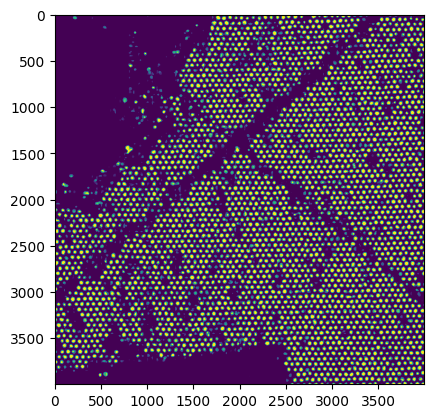

In [10]:
plt.imshow(mask_preditions)
plt.show()

In [11]:
# Convert to 8 bits image
mask_preditions_thresh = utils.convert_8bits(mask_preditions > 0.5)

# Close open circle countours
mask_preditions_thresh = morphology.closing(mask_preditions_thresh, morphology.square(10))

# Label the objects in the binary image
mask_preditions_labels, num_objects_2 = measure.label(mask_preditions_thresh, background=0, return_num=True)

# Get the properties of the labeled regions
pred_regions  = measure.regionprops(mask_preditions_labels)

Number of objects: 3275


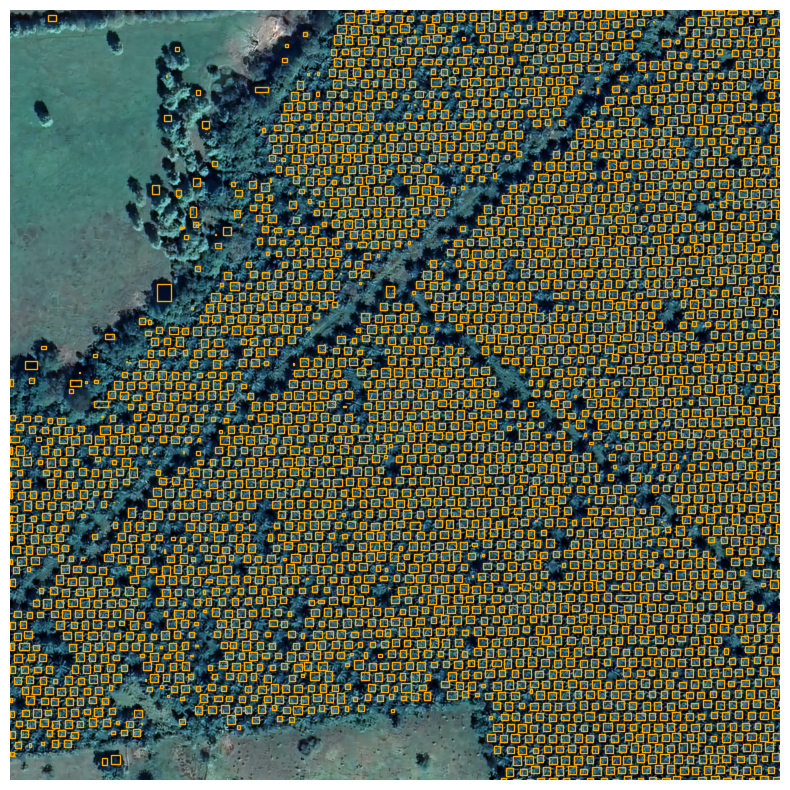

In [13]:
print(f'Number of objects: {num_objects_2}')

fig, axs = plt.subplots(figsize = (10,10))
axs.imshow(img)
axs.axis('off')

# Draw rectangles around each object
for region in pred_regions:
    minr, minc, maxr, maxc = region.bbox
    rect = Rectangle((minc, minr), maxc - minc, maxr - minr, 
                     edgecolor='orange', facecolor='none', linewidth=1)
    axs.add_patch(rect)

plt.savefig("plot.png", format="png")  # You can specify the file path here

plt.show()